In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Datasets

In [2]:
train = pd.read_csv('train.csv')
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [3]:
test = pd.read_csv('test.csv')
test.head()

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.


### Check for null values

In [4]:
train.isnull().any()

id               False
comment_text     False
toxic            False
severe_toxic     False
obscene          False
threat           False
insult           False
identity_hate    False
dtype: bool

In [5]:
train.columns

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object')

In [6]:
types = ['toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate']

### Data visualization

<AxesSubplot:title={'center':'Correlation of features and targets'}>

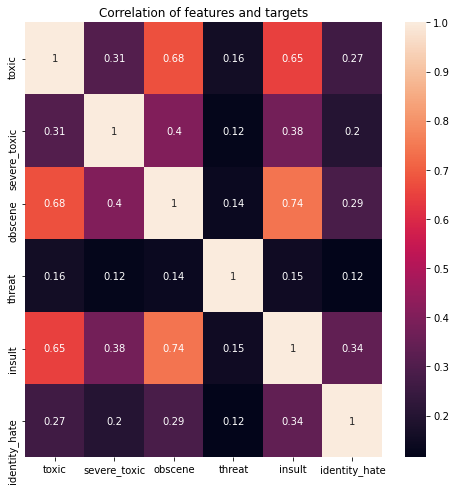

In [7]:
target_data = train[types]
plt.figure(figsize=(8, 8))
plt.title('Correlation of features and targets')
sns.heatmap(target_data.corr(), annot=True)

So here, all classes are not independent but rather dependent or correlated.

In [8]:
counts = []
for i in types:
    counts.append(train[i].sum())

<AxesSubplot:>

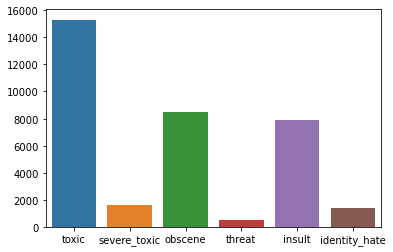

In [9]:
sns.barplot(x = types, y = counts)

It looks like the train dataset is highly skewed data.

Most of the comments do not belong to any of these categories.


### Text cleaning

In [10]:
import re
import string
from string import punctuation
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
import itertools

In [11]:
stop_words = set(stopwords.words('english'))

In [12]:
def cleanData(text, lowercase = True, remove_stops = True, stemming = False, lemmatization = False):
    txt = str(text)
    
    # Replace apostrophes with standard lexicons
    txt = txt.replace("isn't", "is not")
    txt = txt.replace("aren't", "are not")
    txt = txt.replace("ain't", "am not")
    txt = txt.replace("won't", "will not")
    txt = txt.replace("didn't", "did not")
    txt = txt.replace("shan't", "shall not")
    txt = txt.replace("haven't", "have not")
    txt = txt.replace("hadn't", "had not")
    txt = txt.replace("hasn't", "has not")
    txt = txt.replace("don't", "do not")
    txt = txt.replace("wasn't", "was not")
    txt = txt.replace("weren't", "were not")
    txt = txt.replace("doesn't", "does not")
    txt = txt.replace("'s", " is")
    txt = txt.replace("'re", " are")
    txt = txt.replace("'m", " am")
    txt = txt.replace("'d", " would")
    txt = txt.replace("'ll", " will")
    txt = txt.replace("--th", " ")
    
    # More cleaning
    txt = re.sub(r"alot", "a lot", txt)
    txt = re.sub(r"what's", "", txt)
    txt = re.sub(r"What's", "", txt)
    
    # Remove urls and emails
    txt = re.sub(r'^https?:\/\/.*[\r\n]*', ' ', txt, flags=re.MULTILINE)
    txt = re.sub(r'[\w\.-]+@[\w\.-]+', ' ', txt, flags=re.MULTILINE)
    
    # Replace words like sooooooo with so
    txt = ''.join(''.join(s)[:2] for _, s in itertools.groupby(txt))
    
    # Remove punctuation from text
    txt = ''.join([c for c in text if c not in punctuation])
    
    # Remove all symbols
    txt = re.sub(r'[^A-Za-z\s]',r' ',txt)
    txt = re.sub(r'\n',r' ',txt)
    
    if lowercase:
        txt = " ".join([w.lower() for w in txt.split()])
        
    if remove_stops:
        txt = " ".join([w for w in txt.split() if w not in stop_words])
        
    if stemming:
        ps = PorterStemmer()
        txt = " ".join([ps.stem(w) for w in txt.split()])
        
    if lemmatization:
        wordnet_lemmatizer = WordNetLemmatizer()
        txt = " ".join([wordnet_lemmatizer.lemmatize(w, pos='v') for w in txt.split()])
        
    return txt

In [13]:
train['comment_text'] = train['comment_text'].map(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=False, lemmatization = False))

In [14]:
test['comment_text'] = test['comment_text'].map(lambda x: cleanData(x, lowercase=True, remove_stops=True, stemming=False, lemmatization = False))

In [146]:
x_train = train["comment_text"].fillna("fillna").values

In [147]:
x_train.shape

(159571,)

In [148]:
x_test = test["comment_text"].fillna("fillna").values

In [149]:
y_train = train[types].values

In [150]:
y_train.shape

(159571, 6)

### Tokens and sequence

In [151]:
max_features = 100000
maxlen = 200
embed_size = 300

In [140]:
from tensorflow.keras.preprocessing import text, sequence
from tensorflow.keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D
from tensorflow.keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D

In [152]:
tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(x_train) + list(x_test))
x_train = tokenizer.texts_to_sequences(x_train)
x_test = tokenizer.texts_to_sequences(x_test)
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

### Saving the tokenizer

In [94]:
import joblib

In [153]:
joblib.dump(tokenizer, 'newtokens.save')

['newtokens.save']

### Model

In [23]:
from tensorflow.keras.models import Model

In [24]:
filter_sizes = [1,2,3,5]
num_filters = 32

In [25]:
def get_model():    
    inp = Input(shape=(maxlen, ))
    x = Embedding(max_features, embed_size)(inp)
    x = SpatialDropout1D(0.4)(x)
    x = Reshape((maxlen, embed_size, 1))(x)
    
    conv_0 = Conv2D(num_filters, kernel_size=(filter_sizes[0], embed_size), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_1 = Conv2D(num_filters, kernel_size=(filter_sizes[1], embed_size), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_2 = Conv2D(num_filters, kernel_size=(filter_sizes[2], embed_size), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    conv_3 = Conv2D(num_filters, kernel_size=(filter_sizes[3], embed_size), kernel_initializer='normal',
                                                                                    activation='elu')(x)
    
    maxpool_0 = MaxPool2D(pool_size=(maxlen - filter_sizes[0] + 1, 1))(conv_0)
    maxpool_1 = MaxPool2D(pool_size=(maxlen - filter_sizes[1] + 1, 1))(conv_1)
    maxpool_2 = MaxPool2D(pool_size=(maxlen - filter_sizes[2] + 1, 1))(conv_2)
    maxpool_3 = MaxPool2D(pool_size=(maxlen - filter_sizes[3] + 1, 1))(conv_3)
        
    z = Concatenate(axis=1)([maxpool_0, maxpool_1, maxpool_2, maxpool_3])   
    z = Flatten()(z)
    z = Dropout(0.1)(z)
        
    outp = Dense(6, activation="sigmoid")(z)
    
    model = Model(inputs=inp, outputs=outp)
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

    return model

In [26]:
model = get_model()

In [27]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 300)     30000000    input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 200, 300)     0           embedding[0][0]                  
__________________________________________________________________________________________________
reshape (Reshape)               (None, 200, 300, 1)  0           spatial_dropout1d[0][0]          
______________________________________________________________________________________________

### Train and Test split

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
x_tra, x_val, y_tra, y_val = train_test_split(x_train, y_train, train_size=0.95, random_state=233)

In [30]:
x_tra.shape

(151592, 200)

In [31]:
x_val.shape

(7979, 200)

In [32]:
y_tra.shape

(151592, 6)

In [33]:
y_val.shape

(7979, 6)

In [34]:
model.fit(x_tra, y_tra, batch_size=32, epochs=1, validation_data=(x_val, y_val), verbose=1)

Train on 151592 samples, validate on 7979 samples
151592/151592 [==============================] - 4985s 33ms/sample - loss: 0.0604 - accuracy: 0.9794 - val_loss: 0.0515 - val_accuracy: 0.9808


In [93]:
model.save('newmodel.h5')

### Predicting for test dataset

In [35]:
y_pred = model.predict(x_test)

submission = pd.read_csv('sample_submission.csv')
submission[types] = y_pred

In [36]:
submission.head()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,0.994692,0.067743,0.914499,0.016144,0.871545,0.039531
1,0000247867823ef7,0.003758,0.000048,0.000737,0.000050,0.000682,0.000105
2,00013b17ad220c46,0.068574,0.000551,0.007074,0.000836,0.006709,0.000744
3,00017563c3f7919a,0.002806,0.000062,0.000844,0.000096,0.000499,0.000073
4,00017695ad8997eb,0.013982,0.000261,0.002863,0.000787,0.001723,0.000416


In [37]:
submission.tail()

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
153159,fffcd0960ee309b5,0.029459,0.000280,0.004565,0.000443,0.002818,0.000365
153160,fffd7a9a6eb32c16,0.169740,0.001189,0.012621,0.002628,0.014245,0.002029
153161,fffda9e8d6fafa9e,0.008518,0.000085,0.002112,0.000066,0.001356,0.000204
153162,fffe8f1340a79fc2,0.016655,0.000106,0.001201,0.000253,0.001987,0.002624
153163,ffffce3fb183ee80,0.984154,0.009984,0.692282,0.006233,0.396666,0.019966


In [38]:
submission.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,153164.000000,153164.000000,153164.000000,1.531640e+05,153164.000000,153164.000000
mean,0.237142,0.011298,0.115069,3.466415e-03,0.089091,0.013150
std,0.360435,0.056235,0.263824,2.359406e-02,0.209008,0.063630
min,0.000090,0.000002,0.000016,8.636337e-07,0.000023,0.000004
25%,0.004224,0.000062,0.000644,7.621756e-05,0.000627,0.000137
50%,0.019070,0.000205,0.002321,2.845310e-04,0.002304,0.000446
75%,0.385763,0.001422,0.029853,1.378695e-03,0.032441,0.003204
max,0.999987,0.999169,0.999951,9.999120e-01,0.998901,0.999081


In [39]:
submission.to_csv('predictions.csv', index=False)

### Dynamic input

In [171]:
s = ["This picture is so good"]

In [172]:
t = joblib.load('newtokens.save')

In [173]:
ts= t.texts_to_sequences(s)

In [174]:
s_data = sequence.pad_sequences(ts, maxlen=200)

In [175]:
s_data.shape

(1, 200)

In [176]:
p = model.predict(s_data)

In [177]:
p.shape

(1, 6)

In [178]:
p

array([[0.02407368, 0.00081025, 0.00527213, 0.00082502, 0.00319169,
        0.00073162]], dtype=float32)

In [179]:
new_p = [i*100 for i in p]
new_p

[array([2.4073677 , 0.08102503, 0.52721334, 0.08250213, 0.31916925,
        0.07316174], dtype=float32)]